In [1]:
import OpenEXR, Imath, numpy as np

def read_exr(path, channel="Z"):
    """
    Read one channel from an OpenEXR file, with fallback support for depth stored in RGB.
    Returns a 2-D float32 NumPy array.

    Parameters
    ----------
    path : str
        Path to the .exr file.
    channel : str, optional
        Which channel to read ("R", "G", "B", "A", "Z", …).
        Default is "Z" because we usually want depth.
        If "Z" is not found, will try to read depth from RGB channels.

    Raises
    ------
    ValueError if the requested channel is not present and no fallback is available.
    """
    exr = OpenEXR.InputFile(path)
    hdr = exr.header()

    # Image resolution ------------------------------------------------------
    dw = hdr["dataWindow"]
    width  = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1

    print(f"Available channels: {hdr['channels']}")
    
    # Check if requested channel exists
    if channel in hdr["channels"]:
        # Read the requested channel directly
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        raw = exr.channel(channel, pt)
        arr = np.frombuffer(raw, dtype=np.float32).reshape(height, width)
        return arr
    
    # Fallback: if looking for depth channel and RGB are available
    elif channel in ["Z", "V", "Depth"] and all(c in hdr["channels"] for c in ["R", "G", "B"]):
        print(f"Channel '{channel}' not found. Reading depth from RGB channels...")
        
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        
        # Read all RGB channels
        r_raw = exr.channel("R", pt)
        g_raw = exr.channel("G", pt)
        b_raw = exr.channel("B", pt)
        
        r_arr = np.frombuffer(r_raw, dtype=np.float32).reshape(height, width)
        g_arr = np.frombuffer(g_raw, dtype=np.float32).reshape(height, width)
        b_arr = np.frombuffer(b_raw, dtype=np.float32).reshape(height, width)
        
        # Check if all channels are identical (grayscale depth)
        if np.allclose(r_arr, g_arr) and np.allclose(g_arr, b_arr):
            print("RGB channels are identical - using R channel for depth")
            return r_arr
        else:
            # If channels differ, average them or use just R channel
            print("RGB channels differ - averaging for depth")
            return (r_arr + g_arr + b_arr) / 3.0
    
    # Fallback: if looking for depth and only one RGB channel is available
    elif channel in ["Z", "V", "Depth"] and "R" in hdr["channels"]:
        print(f"Channel '{channel}' not found. Using R channel for depth...")
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        raw = exr.channel("R", pt)
        arr = np.frombuffer(raw, dtype=np.float32).reshape(height, width)
        return arr
    
    else:
        raise ValueError(
            f'Channel "{channel}" not found. Available: {list(hdr["channels"])}'
        )

Available channels: {'B': FLOAT (1, 1), 'G': FLOAT (1, 1), 'R': FLOAT (1, 1)}
Channel 'V' not found. Reading depth from RGB channels...
RGB channels are identical - using R channel for depth


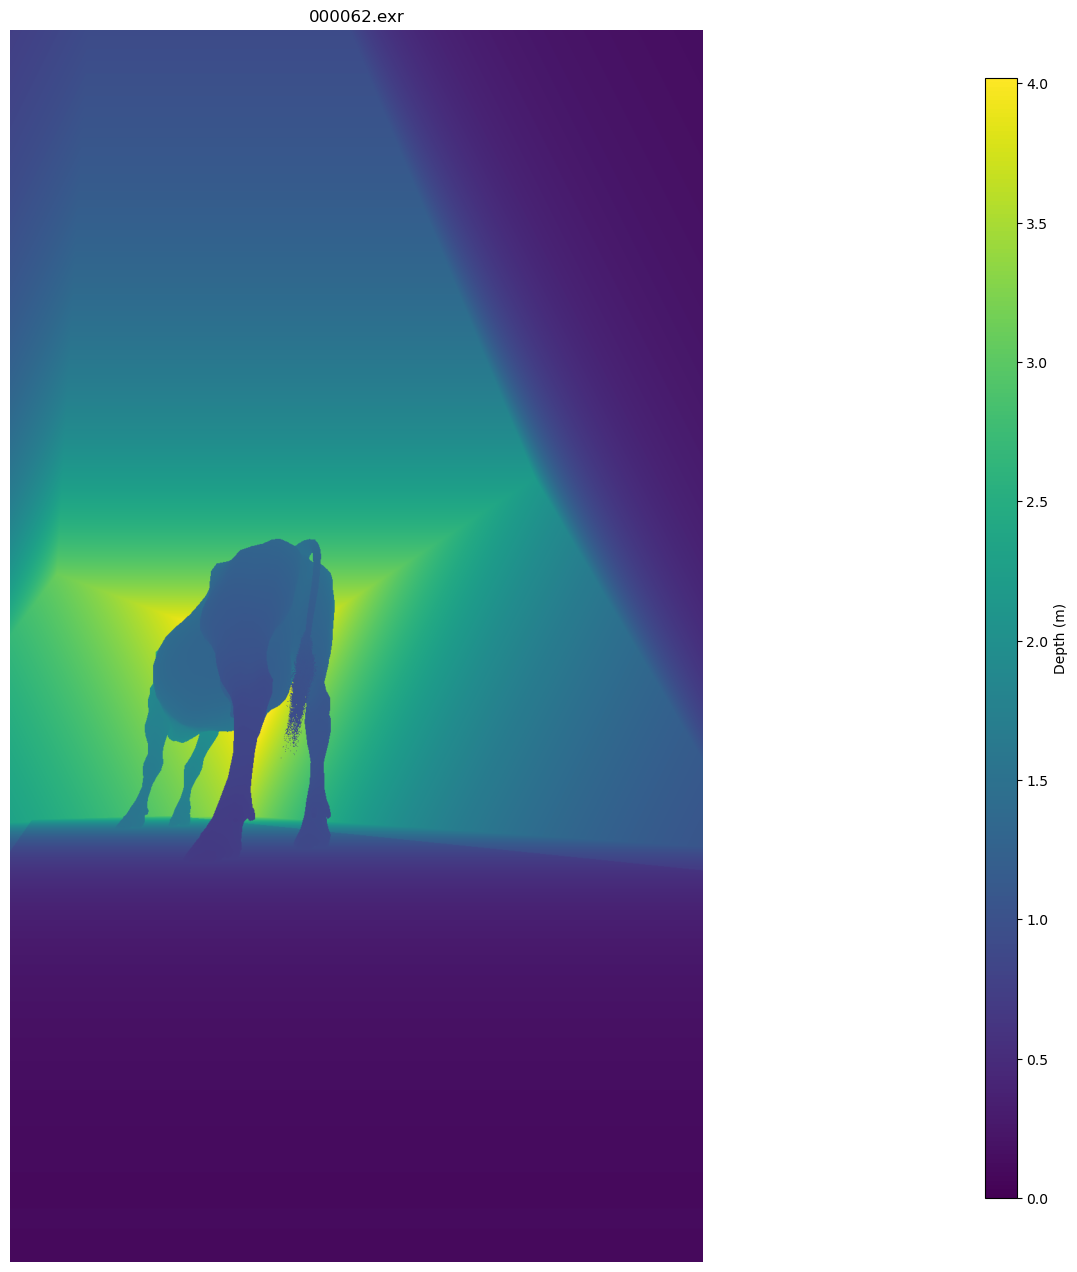

In [2]:
# Paths to your depth EXRs
depth_files = [
    # 'data/renders/cow_boxed/depth_front_left/Camera.front_depth.exr',
    # 'data/renders/cow_boxed/depth_front_left/Camera.left_depth.exr',

    # Multilayer EXR
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_left_lower_offset=70cm/2025-07-28_091020/000060.exr',
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_093434/000060.exr',
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_093140/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_093946/000060.exr'

    # EXR
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_left_lower_offset=70cm/2025-07-28_091447/000060.exr',
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_left_lower_offset=70cm/2025-07-28_091959/000060.exr',

    # EXR BW (Passes: Combined, Z)
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_134947/000060.exr'

    # EXR BW (Passes: Z)
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_155547/000060.exr'

    # EXR BW (Passes: Z) [Postprocessing: Sequencer]
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_155907/000060.exr'

    # EXR BW (Passes: Z) [Depth]
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_160047/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=left-wall-touch/depth_front_lower/2025-07-28_163931/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=default/render=depth/front_upper/2025-07-28_172056/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=default/render=depth/front_upper/2025-07-28_173809/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=default/render=depth/front_upper/2025-07-28_174318/000001.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=default/render=depth/front_lower/2025-07-28_174736/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v1/case=default/render=depth/front_lower/2025-07-28_174736/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v2/case=default/render=depth/front_lower/2025-07-28_180202/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v2/case=default/render=depth/front_lower/2025-07-28_180526/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v2/case=default/render=depth/front_lower/2025-07-28_180752/000060.exr'
    # 'data/renders/cow_boxed/sliding_clip_120s_v2/case=default/render=depth/front_lower/2025-07-28_181146/000060.exr'
    # 'data/renders/cow_boxed/static_pose_frame=60/case=default/render=depth/front_upper/2025-08-01_183209/000060.exr'
    'data/prod/data_generation_source_v1/back_lower_2025-08-01_190727/000062.exr'
]

# CHANNEL='Z'
CHANNEL='V'

import matplotlib.pyplot as plt

# 1) make room on the right for the cbar
fig, axes = plt.subplots(1, len(depth_files), 
                         figsize=(16*len(depth_files), 16))
if len(depth_files) == 1:
    axes = [axes]

# 2) plot each depth map
for ax, path in zip(axes, depth_files):
    depth = read_exr(path, channel=CHANNEL)
    im = ax.imshow(depth, vmin=0)
    ax.set_title(path.split("/")[-1])
    ax.axis("off")

# 3) carve out space and stick the cbar there
fig.subplots_adjust(right=0.85)                    # leave 15% on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])     # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label="Depth (m)")

plt.show()